In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

import dask.dataframe as dd

sys.path.append("../")
from src.utils import *
from src.LSN_roi import *

from models import dp_loss as dpl
from models import dp_utils as dpu

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Paths

In [2]:
project_dir = "../"
data_dir = "/home/nikhil/projects/brain_changes/data/ukbb/"

freesurfer_csv = f"{data_dir}imaging/freesurfer/ukb47552_followup_subset.csv"

train_csv = f"{project_dir}metadata/metadata_train.csv"
test_csv = f"{project_dir}metadata/metadata_test.csv"

freesurfer_fields = f"{project_dir}/metadata/ukbb_freesurfer_fields.txt"


## Filter followup subject using Dask dataframe (pandas will crash)

In [3]:
# import dask.dataframe as dd

# # Grab eids with ses-3 data
# freesurfer_df = pd.read_csv(freesurfer_csv,usecols=["eid","26501-3.0"])
# freesurfer_eids = freesurfer_df[~freesurfer_df["26501-3.0"].isna()]["eid"]

# # Read entire CSV using dask
# freesurfer_df = dd.read_csv(freesurfer_csv)
# followup_freesurfer_df = freesurfer_df[freesurfer_df["eid"].isin(freesurfer_eids)].compute()

# # Save filtered df
# followup_freesurfer_df.to_csv(f"{data_dir}imaging/freesurfer/ukb47552_followup_subset.csv")

## Grab phenotype fields (e.g. Thicknes, Volume, Area)

In [3]:
freesurfer_fields_df = pd.read_csv(freesurfer_fields,sep="	")
freesurfer_fields_df["phenotype"] = freesurfer_fields_df["Description"].str.split(" ",1,expand=True)[0]
freesurfer_fields_df["phenotype"] = freesurfer_fields_df["phenotype"].replace({"Mean":"Mean Thickness"})
CT_fields = freesurfer_fields_df[freesurfer_fields_df["phenotype"]=="Mean Thickness"]["Field ID"]
volume_fields = freesurfer_fields_df[freesurfer_fields_df["phenotype"]=="Volume"]["Field ID"]

print(f"number of CT fields: {len(CT_fields)}, volume fields: {len(volume_fields)}")

number of CT fields: 62, volume fields: 62


## Read DKT volumes 

In [4]:
pheno_fields = CT_fields # + volume_fields
pheno_cols_ses2 = list(pheno_fields.astype(str) + "-2.0")
pheno_cols_ses3 = list(pheno_fields.astype(str) + "-3.0")
usecols = ["eid"] + pheno_cols_ses2 + pheno_cols_ses3

print(f"reading {len(usecols)} columes")

freesurfer_df = pd.read_csv(freesurfer_csv, usecols=usecols)

# Remove eids with missing 2nd or 3rd ses data
eid_missing_data = freesurfer_df[freesurfer_df.isna().any(axis=1)]["eid"].values
print(f"number participants missing 2nd or 3rd ses freesurfer data: {len(eid_missing_data)}")

freesurfer_eids = freesurfer_df[~freesurfer_df["eid"].isin(eid_missing_data)]["eid"].values

freesurfer_df.head()

reading 125 columes
number participants missing 2nd or 3rd ses freesurfer data: 63


,eid,27174-2.0,27174-3.0,27175-2.0,27175-3.0,27176-2.0,27176-3.0,27177-2.0,27177-3.0,27178-2.0,...,27293-2.0,27293-3.0,27294-2.0,27294-3.0,27295-2.0,27295-3.0,27296-2.0,27296-3.0,27297-2.0,27297-3.0
0,1000635,2.786,2.874,2.910,2.852,2.275,2.307,3.389,3.379,2.836,...,2.387,2.435,2.967,2.958,2.707,2.628,2.229,2.142,2.875,2.750
1,1008391,3.191,2.875,3.080,3.037,2.273,2.143,3.004,2.571,2.846,...,2.588,2.592,3.073,2.859,2.839,2.770,3.086,3.322,3.255,3.003
2,1010129,2.329,1.870,2.836,2.798,1.995,1.943,3.302,3.193,2.812,...,2.376,2.395,3.081,3.086,2.993,2.945,3.016,3.032,3.193,3.168
3,1010994,2.785,2.581,2.671,2.603,2.060,1.819,3.144,3.225,2.793,...,2.513,2.416,2.919,2.881,2.654,2.581,2.088,2.161,2.912,2.866
4,1013774,2.963,3.191,2.617,2.856,2.035,2.050,2.751,3.385,2.830,...,2.274,2.403,3.041,3.008,2.635,2.737,2.527,2.696,2.983,3.263


In [5]:
train_df = pd.read_csv(train_csv)
train_eids = train_df["eid"]
train_eids_avail = set(train_eids) & set(freesurfer_eids)
train_df = train_df[train_df["eid"].isin(train_eids_avail)].reset_index()

test_df = pd.read_csv(test_csv)
test_eids = test_df["eid"]
test_eids_avail = set(test_eids) & set(freesurfer_eids)
test_df = test_df[test_df["eid"].isin(test_eids_avail)].reset_index()

print(f"train samples: {len(train_eids)}, freesurfer data available: {len(train_eids_avail)}")
print(f"test samples: {len(test_eids)}, freesurfer data available: {len(test_eids_avail)}")

train samples: 2145, freesurfer data available: 1909
test samples: 1057, freesurfer data available: 958


## Data-loaders

In [7]:
# n_samples = 50

batch_size = 100
transform = "random_swap"

usecols = ["eid"] + pheno_cols_ses2 + pheno_cols_ses3

data_df = pd.read_csv(freesurfer_csv, usecols=usecols)

train_dataset = UKBB_ROI_Dataset(train_df, data_df, pheno_cols_ses2, pheno_cols_ses3, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = UKBB_ROI_Dataset(test_df, data_df, pheno_cols_ses2, pheno_cols_ses3, transform=None)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# iter(train_dataloader).next()
print(f"len train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

len train dataset: 1909, test dataset: 958


## CUDA

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

## Train model 

In [9]:
n_epochs = 1
input_size = len(pheno_cols_ses2)
hidden_size = 25
lr = 0.001

model = LSN_FF(input_size,hidden_size=hidden_size) # alternative toy model: LSN()
model.train()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5)                                                                                               
criterion = nn.MSELoss()                        

# using subset of train dataloader for debug
model, batch_loss_df, epoch_loss_df = train(model,train_dataloader,optimizer,criterion,n_epochs)

Starting epoch 1
epoch 0 loss: 0.3194


,epoch_loss
0,0.294067


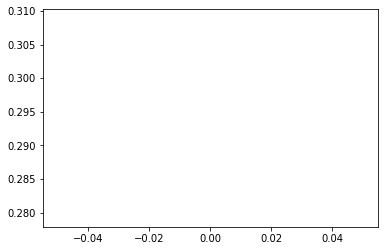

In [10]:
# train time: 373s before dask

plt.plot(epoch_loss_df)
epoch_loss_df

## Test perf

In [11]:
y_test = test_df[["age_at_ses2", "age_at_ses3"]].values #[:n_samples]

model.eval()

batch_pred_list, test_MAE1, test_MAE2 = test(model, test_dataloader)
y_pred = np.squeeze(np.vstack(batch_pred_list))

test_r1 = stats.pearsonr(y_pred[:,0],y_test[:,0])[0]
test_r2 = stats.pearsonr(y_pred[:,1],y_test[:,1])[0]   

test_age_1 = y_test[:,0]
test_age_2 = y_test[:,1]

test_brainage_1 = y_pred[:,0] # for two timepoints y is a matrix
test_brainage_2 = y_pred[:,1]                                    

df = pd.DataFrame()
df["eid"] = np.arange(len(y_test))
df["test_age_1"] = test_age_1
df["test_age_2"] = test_age_2
df["test_brainage_1"] = test_brainage_1
df["test_brainage_2"] = test_brainage_2
df["test_MAE1"] = test_MAE1                    
df["test_MAE2"] = test_MAE2
df["test_r1"] = test_r1
df["test_r2"] = test_r2

/home/nikhil/projects/green_comp_neuro/green_compute/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


## Generate configs for CC runs

In [42]:
config_df = pd.DataFrame(columns=["hidden_size","transform","phenotype"])
hidden_size_list = [10,50,100]
transform_list = [None, "random_swap"]
phenotype_list = ["CT"] #,"volume","both"

i = 0
for hidden_size in hidden_size_list:
    for transform in transform_list:
        for phenotype in phenotype_list:
            config_df.loc[i] = [hidden_size,transform,phenotype]
            i += 1

print(config_df.shape)
config_df

(6, 3)


,hidden_size,transform,phenotype
0,10,None,CT
1,10,random_swap,CT
2,50,None,CT
3,50,random_swap,CT
4,100,None,CT
5,100,random_swap,CT


In [15]:
# run_id = "run_1"
# config_path = f"../results/LSN_roi/configs/config_{run_id}.csv"
# config_df.to_csv(config_path)

## Plot batch runs

In [7]:
def collate_results(file_prefix, config_id_list):
    results_df = pd.DataFrame()
    for config_id in config_id_list:
        results_csv = f"{file_prefix}_{config_id}.csv"
        _df = pd.read_csv(results_csv)
        _df["config_id"] = config_id
        results_df = results_df.append(_df)

    return results_df


In [8]:
run_id = "run_2"
config_id_list = np.arange(6)

loss_csv = f"../results/LSN_roi/{run_id}/freesurfer_train_loss_config"
perf_csv = f"../results/LSN_roi/{run_id}/freesurfer_perf_config"

loss_df = collate_results(loss_csv, config_id_list)
perf_df = collate_results(perf_csv, config_id_list)

loss_df = loss_df.rename(columns={"Unnamed: 0":"epoch"})

In [9]:
perf_df.head()

,Unnamed: 0,eid,test_age_1,test_age_2,test_brainage_1,test_brainage_2,test_MAE1,test_MAE2,test_r1,test_r2,visit_order,config_id
0,0,4071544,66.0,68.0,61.757732,65.429665,4.242268,2.570335,-0.083192,-0.052525,"B,F",0
1,1,6005293,61.0,63.0,62.061775,65.495670,1.061775,2.495667,-0.083192,-0.052525,"B,F",0
2,2,5739520,61.0,63.0,61.921850,65.286194,0.921848,2.286194,-0.083192,-0.052525,"B,F",0
3,3,1308382,51.0,53.0,61.974180,65.398964,10.974178,12.398968,-0.083192,-0.052525,"B,F",0
4,4,2991501,58.0,60.0,61.908280,65.374120,3.908279,5.374119,-0.083192,-0.052525,"B,F",0


## Plot learning curves

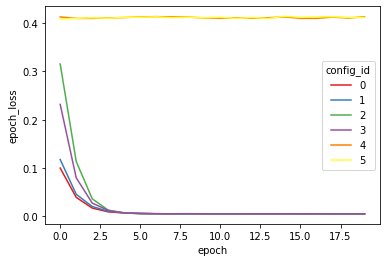

In [10]:
g = sns.lineplot(x="epoch", y="epoch_loss", data=loss_df, hue="config_id", palette="Set1")

## Plot prediction perf

config_id  visit_order
0          B,F             6.144794
           F,B             6.500193
1          B,F             6.256878
           F,B             6.121485
2          B,F             6.190140
           F,B             6.375304
3          B,F             6.231447
           F,B             6.199442
4          B,F            62.277662
           F,B            64.584551
5          B,F            62.277662
           F,B            64.584551
Name: test_MAE, dtype: float64


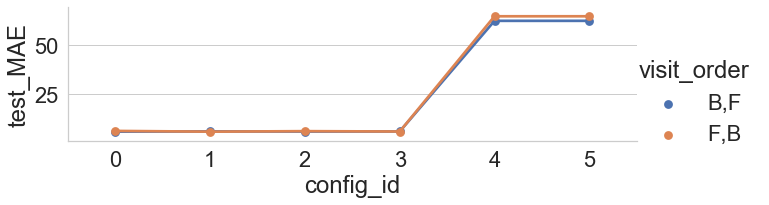

In [13]:
plot_df = perf_df.copy()
plot_df["test_MAE"] = 0.5 * (plot_df["test_MAE1"] + plot_df["test_MAE1"])

print(plot_df.groupby(["config_id", "visit_order"]).mean()["test_MAE"])

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="test_MAE",x="config_id",hue="visit_order", height=3, aspect=3, kind="point", 
                    sharey=False, data=plot_df)

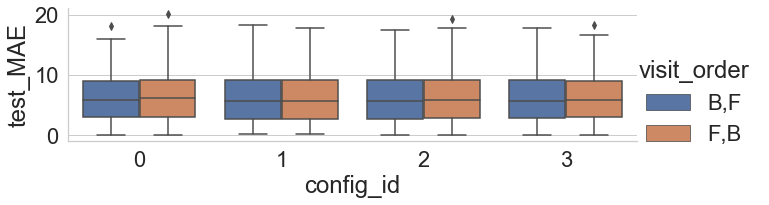

In [14]:
plot_df = plot_df[plot_df["config_id"].isin([0,1,2,3])]

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="test_MAE",x="config_id",hue="visit_order", height=3, aspect=3, kind="box", 
                    sharey=False, data=plot_df)

n BBs: 0 (0.000%)


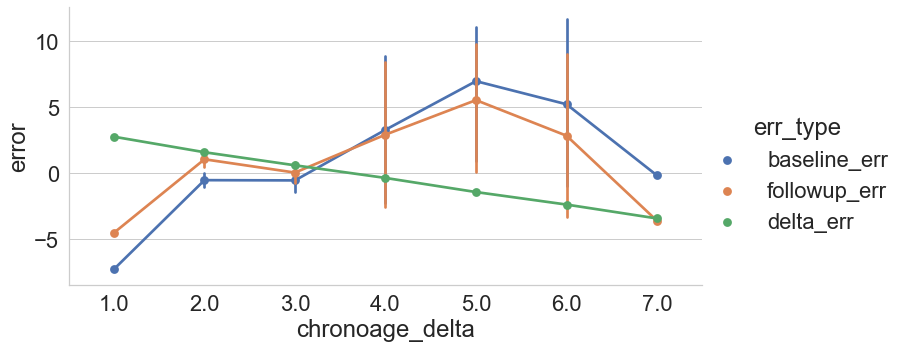

In [18]:
plot_df = perf_df.copy()
plot_df = plot_df[plot_df["config_id"].isin([0]) & plot_df["visit_order"].isin(["B,F"])]

plot_df["baseline_err"] = plot_df["test_brainage_1"] - plot_df["test_age_1"]
plot_df["followup_err"] = plot_df["test_brainage_2"] - plot_df["test_age_2"]

plot_df["brainage_delta"] = plot_df["test_brainage_2"] - plot_df["test_brainage_1"]
plot_df["chronoage_delta"] = plot_df["test_age_2"] - plot_df["test_age_1"]
plot_df["delta_err"] = plot_df["brainage_delta"] - plot_df["chronoage_delta"]

plot_df["Benjamin_Button"] = plot_df["test_brainage_2"] < plot_df["test_brainage_1"]

n_BBs = plot_df["Benjamin_Button"].sum()
print(f"n BBs: {n_BBs} ({100*n_BBs/len(plot_df):4.3f}%)")

plot_df_melt = plot_df.melt(id_vars=["eid", "visit_order", "test_age_1", "test_brainage_1",	"test_age_2", "test_brainage_2", "chronoage_delta", "brainage_delta"], 
              value_vars=['baseline_err', 'followup_err', 'delta_err'],
              var_name='err_type', value_name='error')

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    # fig, ax = plt.subplots(figsize=(20,10))
    g = sns.catplot(x="chronoage_delta",y="error", hue="err_type", kind="point", data=plot_df_melt, aspect=2)


chronoage_delta  err_type    
1.0              baseline_err    7.293327
                 delta_err       2.762837
                 followup_err    4.530490
2.0              baseline_err    6.226293
                 delta_err       1.584175
                 followup_err    6.238261
3.0              baseline_err    5.755401
                 delta_err       0.592545
                 followup_err    5.725692
4.0              baseline_err    5.563671
                 delta_err       0.366738
                 followup_err    5.481185
5.0              baseline_err    9.907120
                 delta_err       1.438051
                 followup_err    8.780799
6.0              baseline_err    7.755174
                 delta_err       2.387486
                 followup_err    6.461366
7.0              baseline_err    0.179640
                 delta_err       3.441810
                 followup_err    3.621450
Name: abs_error, dtype: float64


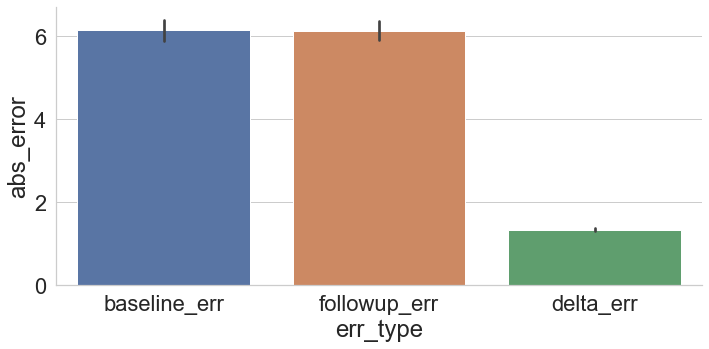

In [23]:

plot_df_melt["abs_error"] = np.abs(plot_df_melt["error"]) 

print(plot_df_melt.groupby(["chronoage_delta","err_type"]).mean()["abs_error"])

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="err_type",y="abs_error", kind="bar", data=plot_df_melt,aspect=2)

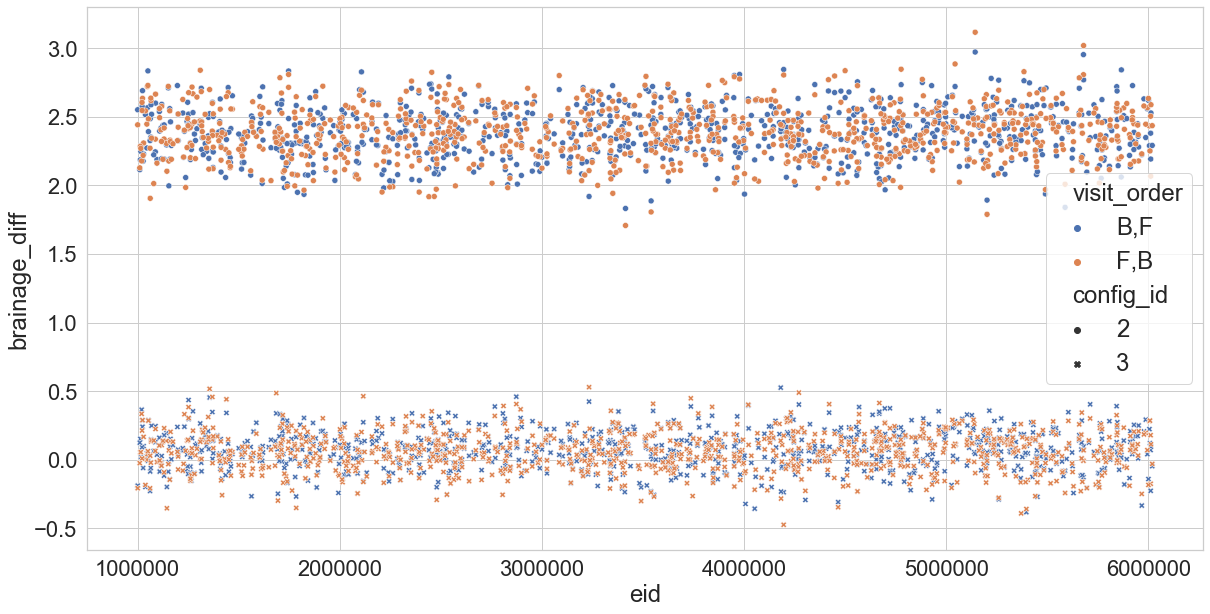

In [10]:
plot_df = perf_df.copy()
plot_df = plot_df[plot_df["config_id"].isin([2,3])]

plot_df["test_MAE"] = 0.5 * (plot_df["test_MAE1"] + plot_df["test_MAE1"])
plot_df["brainage_diff"] = plot_df["test_brainage_2"] - plot_df["test_brainage_1"]
plot_df["chronoage_diff"] = plot_df["test_age_2"] - plot_df["test_age_1"]

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(20,10))
    g = sns.scatterplot(x="eid",y="brainage_diff",hue="visit_order", style="config_id",data=plot_df, ax=ax)

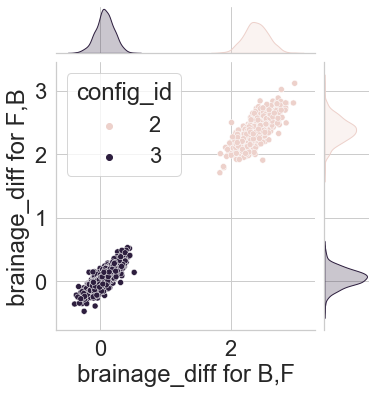

In [11]:
plot_df1 = plot_df[plot_df["visit_order"]=="B,F"][["eid","config_id","brainage_diff"]]
plot_df2 = plot_df[plot_df["visit_order"]=="F,B"][["eid","config_id","brainage_diff"]]
plot_df_long = pd.merge(plot_df1,plot_df2,on=["eid","config_id"])
plot_df_long = plot_df_long.rename(columns={"brainage_diff_x":"brainage_diff for B,F", "brainage_diff_y":"brainage_diff for F,B"})

with sns.axes_style("whitegrid"):
    g = sns.jointplot(x="brainage_diff for B,F", y="brainage_diff for F,B", hue="config_id", data=plot_df_long)

# Vector similarity

In [13]:
perf_df.head()

,Unnamed: 0,eid,test_age_1,test_age_2,test_brainage_1,test_brainage_2,test_MAE1,test_MAE2,test_r1,test_r2,visit_order,config_id
0,0,4071544,66.0,68.0,61.757732,65.429665,4.242268,2.570335,-0.083192,-0.052525,"B,F",0
1,1,6005293,61.0,63.0,62.061775,65.495670,1.061775,2.495667,-0.083192,-0.052525,"B,F",0
2,2,5739520,61.0,63.0,61.921850,65.286194,0.921848,2.286194,-0.083192,-0.052525,"B,F",0
3,3,1308382,51.0,53.0,61.974180,65.398964,10.974178,12.398968,-0.083192,-0.052525,"B,F",0
4,4,2991501,58.0,60.0,61.908280,65.374120,3.908279,5.374119,-0.083192,-0.052525,"B,F",0


In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance

chrno_age = perf_df[["test_age_1","test_age_2"]].values
brain_age = perf_df[["test_brainage_1","test_brainage_2"]].values

sim_list = []
for i in range(len(chrno_age)):
    cos_sim = 1 - distance.cosine(chrno_age[i],brain_age[i])
    sim_list.append(cos_sim)

/home/nikhil/projects/green_comp_neuro/green_compute/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


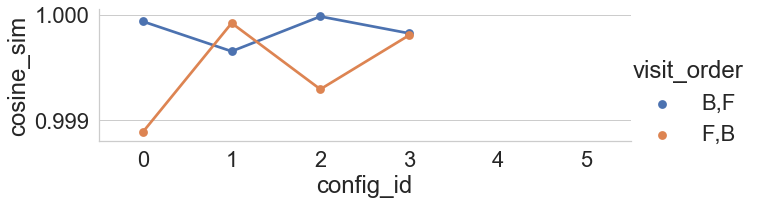

In [15]:
plot_df = perf_df.copy()
plot_df["cosine_sim"] = sim_list

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="cosine_sim",x="config_id",hue="visit_order", height=3, aspect=3, kind="point", 
                    sharey=False, data=plot_df)

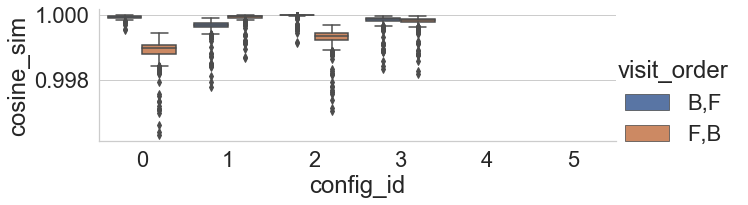

In [17]:
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="cosine_sim",x="config_id",hue="visit_order", height=3, aspect=3, kind="box", 
                    sharey=False, data=plot_df)